# 회귀 실습 - 캐글 주택 가격 회귀 분석 : 고급 회귀 기법 사용

데이터 다운로드  
https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data?select=train.csv  
house_price.csv로 변경하여 저장

* 데이터 설명
    * 79개 변수
    * 미국 아이오와 주의 에임즈 지방의 주택 가격 정보 데이터

성능 평가는 **RMSLE(Root Mean Squared Log Error)** 기반
* 가격이 비싼 주택일수록 예측 결과 오류가 전체 오류에 미치는 비중이 높으므로
* 이것을 상쇄하기 위해 오류값을 로그 변환한 RMSLE 이용
* RMSE를 하되 예측값과 실제값의 로그 변환값을 기반으로 RMSE를 수행 (RMSLE와 동일 방식)

## 전체 회귀 분석 과정
1. 데이터 전처리
2. 선형 회귀 모델 학습/예측/평가
3. 회귀 트리 모델 학습/예측/평가
4. 회귀 모델의 예측 결과 혼합을 통한 최종 예측
5. 스태킹 앙상블 모델을 통한 회귀 예측

# 1. 데이터 전처리

주요피처들  
- 1stFlrSF: First Floor square feet  
- 2ndFlrSF: Second floor square feet  
- GrLivArea: Above grade (ground) living area square feet      
- Bedroom: Bedrooms above grade (does NOT include basement bedrooms)  
- LotArea: Lot size in square feet      
- GarageArea: Size of garage in square feet      
- OverallQual: Rates the overall material and finish of the house  
       10	Very Excellent  
       9	Excellent  
       8	Very Good  
       7	Good  
       6	Above Average  
       5	Average  
       4	Below Average  
       3	Fair  
       2	Poor  
       1	Very Poor	  
- OverallCond: Rates the overall condition of the house  
       10	Very Excellent  
       9	Excellent  
       8	Very Good  
       7	Good  
       6	Above Average	  
       5	Average  
       4	Below Average	  
       3	Fair  
       2	Poor  
       1	Very Poor  
- YearBuilt: Original construction date  
- Neighborhood: Physical locations within Ames city limits  
   Blmngtn  Bloomington Heights  
   Blueste  Bluestem  
   BrDale   Briard

   .....

- RoofMatl: Roof material  
	ClyTile	Clay or Tile  
	CompShg	Standard (Composite) Shingle  
	Membran	Membrane  
	Metal	Metal  
	.....

- RoofStyle: Type of roof  
	Flat	Flat  
	Gable	Gable  
	Gambrel	Gabrel (Barn)  
	.....


In [99]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# 데이터 읽어오기
house_df_org = pd.read_csv('./data/house_price.csv')
house_df_org.head(3)
house_df = house_df_org.copy()

In [7]:
house_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [12]:
# 데이터 타입과 null값 개수 확인
print('데이터 세트의 shape :',house_df.shape)
print('전체 feature들의 type :\n',house_df.dtypes.value_counts())



데이터 세트의 shape : (1460, 81)
전체 feature들의 type :
 object     43
int64      35
float64     3
dtype: int64


In [19]:
# Null 컬럼 확인 : Null 값이 있는 컬럼의 수를 내림차순으로 출력 

isnull_series = house_df.isnull().sum()
print('Null컬럼과 그 건수 : \n',isnull_series[isnull_series>0].sort_values(ascending=False))


Null컬럼과 그 건수 : 
 PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
FireplaceQu      690
LotFrontage      259
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
BsmtExposure      38
BsmtFinType2      38
BsmtFinType1      37
BsmtCond          37
BsmtQual          37
MasVnrArea         8
MasVnrType         8
Electrical         1
dtype: int64


* 데이터 확인 결과
    * 1460개의 레코드 (행,건), 81개의 피처로 구성
    * 피처 타입 : 문자형(object), 숫자형 (정수(int),실수(float))
    * Target을 제외한 80개 피처 중 43개가 문자형, 나머지는 숫자형 
    * 데이터 양에 비해 Null값이 많은 피처 존재
    * 1,000개가 넘는 데이터가 Null인 피처도 존재
    * Null이 너무 많은 피처는 drop할 것

## 회귀 모델 적용 전 타겟값이 정규 분포 형태인지 확인

Text(0.5, 1.0, 'Original Sale Price Histogram')

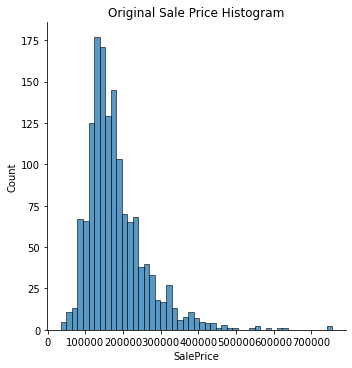

In [23]:
# 타겟 값은 SalePrice
sns.displot(house_df['SalePrice'])
plt.title('Original Sale Price Histogram')


# 결과
# 데이터 값의 분포가 중심에서 왼쪽으로 치우친 형태
# 정규분포에서 벗어나 있음 --> 로그 변환 필요 

* 로그 변환 및 환원
    * 정규 분포가 아닌 결과값을 정규 분포 형태로 변환
    * log1p()이용해 로그 변환한 결과값을 기반으로 학습한 후
    * 예측 시 다시 결과값을 expm1()으로 환원해서 사용

- 로그 함수로 변환  
numpy.log1p()
- 로그 함수 numpy.log1p()로 변환 된 값을 원래 값으로 변환   
numpy.expm1()

Text(0.5, 1.0, 'Log Transformed Sale Price Histogram')

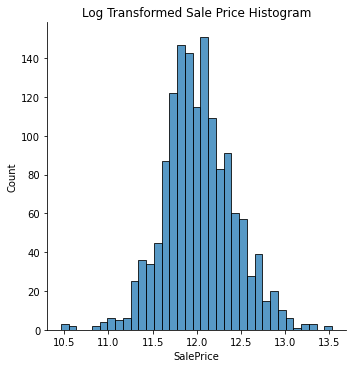

In [24]:
# 결과값을 로그 변환 후 SalePrice 값 분포도 확인
log_SalePrice = np.log1p(house_df['SalePrice'])
sns.displot(log_SalePrice)
plt.title('Log Transformed Sale Price Histogram')


## 로그 변환 / Null이 많은 컬럼과 불필요한 컬럼 삭제 

In [100]:
# Saleprice로그 변환
original_SalePrice = house_df['SalePrice']
house_df['SalePrice'] = np.log1p(house_df['SalePrice'])

# id는 불필요한 컬럼이여서 삭제, Null값이 너무 많은 컬럼도 삭제
house_df.drop(['Id','PoolQC','MiscFeature','Alley','Fence','FireplaceQu'],axis=1, inplace=True)

# drop하지 않는 숫자형 null 컬럼은 평균값으로 대체
house_df.fillna(house_df.mean(), inplace=True)

# null값이 있는 피처명과 타입을 추출
null_column_count = house_df.isnull().sum()[house_df.isnull().sum()>0]
print('## Null 피처 개수 ##: \n',null_column_count)
print('## Null 피처의 Type ##: \n',house_df.dtypes[null_column_count.index])

## Null 피처 개수 ##: 
 MasVnrType       8
BsmtQual        37
BsmtCond        37
BsmtExposure    38
BsmtFinType1    37
BsmtFinType2    38
Electrical       1
GarageType      81
GarageFinish    81
GarageQual      81
GarageCond      81
dtype: int64
## Null 피처의 Type ##: 
 MasVnrType      object
BsmtQual        object
BsmtCond        object
BsmtExposure    object
BsmtFinType1    object
BsmtFinType2    object
Electrical      object
GarageType      object
GarageFinish    object
GarageQual      object
GarageCond      object
dtype: object


## 문자형 피처를 원-핫 인코딩 변환
* 문자열 값은 모두 카테고리 값
* get_dummies()는 자동으로 문자열 피처를 원-핫 인코딩으로 변환하면서 null값은 'None'컬럼으로 대체
* 그러므로 별도의 Null값을 대체하는 로직이 필요 없음

In [36]:
print('get_dummies() 수행 전 데이터 Shape : ',house_df.shape)
house_df_ohe = pd.get_dummies(house_df)
print('get_dummies() 수행 후 데이터 Shape : ',house_df_ohe.shape)

null_column_count = house_df_ohe.isnull().sum()[house_df_ohe.isnull().sum()>0]
print('## Null 피처의 Type :\n',house_df_ohe.dtypes[null_column_count.index])

# 원-핫 인코딩 후 피처가 75 -> 271개로 증가
# null값을 가진 피처는 이제 없음 

get_dummies() 수행 전 데이터 Shape :  (1460, 75)
get_dummies() 수행 후 데이터 Shape :  (1460, 271)
## Null 피처의 Type :
 Series([], dtype: object)


# 2. 선형 회귀 모델 학습/예측/평가

## 여러 모델의 로그 변환된 RMSE를 측정할 함수 생성
* RMSLE (실제 값과 예측 값의 오류를 로그 변환한 뒤 RMSE를 적용) 이용
* 앞에서 이미 log변환 했음
* 그러므로 예측 결과 오류에 RMSE바로 적용하면 RMSLE가 자동으로 측정

In [56]:
from sklearn.metrics import mean_squared_error

# 단일 모델의 RMSE 값을 반환
def get_rmse(model):
    pred = model.predict(x_test)
    mse = mean_squared_error(y_test,pred)
    rmse = np.sqrt(mse)
    print(model.__class__.__name__, '로그 변환된 RMSE : ',np.round(rmse,3))
    return rmse

# get_rmse()를 이용해 여러 모델의 RMSE값을 반환 
def get_rmses(models):
    rmses = []
    for model in models:
        rmse = get_rmse(model)
        rmses.append(rmse)
    return rmses

In [57]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split

y_target = house_df_ohe['SalePrice']
x_features = house_df_ohe.drop('SalePrice',axis = 1,inplace=False)
x_train,x_test,y_train,y_test = train_test_split(x_features,y_target, test_size=0.2, random_state=156)

# LinearRegression, Ridge, Lasso 학습, 예측, 평가
lr_reg = LinearRegression()
lr_reg.fit(x_train,y_train)


ridge_reg = Ridge()
ridge_reg.fit(x_train,y_train)


lasso_reg = Lasso()
lasso_reg.fit(x_train,y_train)

models = [lr_reg,ridge_reg,lasso_reg]
get_rmses(models)

# RMSE값이 낮을수록 성능이 좋은것
# Lasso회귀의 경우 Linear, Ridge 회귀 방식보다 성능이 많이 떨어짐
# 그러므로 Lasso의 경우에는 하이퍼 파라미터 튜닝이 필요함 

LinearRegression 로그 변환된 RMSE :  0.132
Ridge 로그 변환된 RMSE :  0.128
Lasso 로그 변환된 RMSE :  0.176


[0.1318957657915425, 0.1275084633405294, 0.1762825055647141]

## 피처별 회귀 계수를 시각화 후 모델별로 어떠한 피처의 회귀 계수로 구성되는 지 확인


In [40]:
# 상위 10개, 하위 10개의 피처명과 그 회귀 계수 값을 구하는 함수

def get_top_bottom_coef(model, n = 10):
    # coef_ 속성을 기반으로 Series객체 생성, index는 컬럼명
    coef = pd.Series(model.coef_, index=x_features.columns)

    # 상위 10개, 하위 10개의 회귀게수 추출 해 반환
    coef_high = coef.sort_values(ascending=False).head(n)
    coef_low = coef.sort_values(ascending=False).tail(n)
    return coef_high,coef_low




In [69]:
def visualize_coefficient(models):
    # 3개 회귀 모델의 시각화를 위해 3개의 컬럼을 가지는 subplot 생성
    fig, axs = plt.subplots(figsize=(24,10),nrows=1, ncols=3)
    fig.tight_layout() 
    # 입력인자로 받은 list객체인 models에서 차례로 model을 추출하여 회귀 계수 시각화. 
    for i_num, model in enumerate(models):
        # 상위 10개, 하위 10개 회귀 계수를 구하고, 이를 판다스 concat으로 결합. 
        coef_high, coef_low = get_top_bottom_coef(model)
        coef_concat = pd.concat( [coef_high , coef_low] )
        
        # 순차적으로 ax subplot에 barchar로 표현. 한 화면에 표현하기 위해 tick label 위치와 font 크기 조정. 
        axs[i_num].set_title(model.__class__.__name__ +' Coeffiecents', size=25)
        axs[i_num].tick_params(axis="y",direction="in", pad=-120) # 안쪽, 패딩값
        for label in (axs[i_num].get_xticklabels() + axs[i_num].get_yticklabels()):
            label.set_fontsize(22)
        sns.barplot(x=coef_concat.values, y=coef_concat.index , ax=axs[i_num])


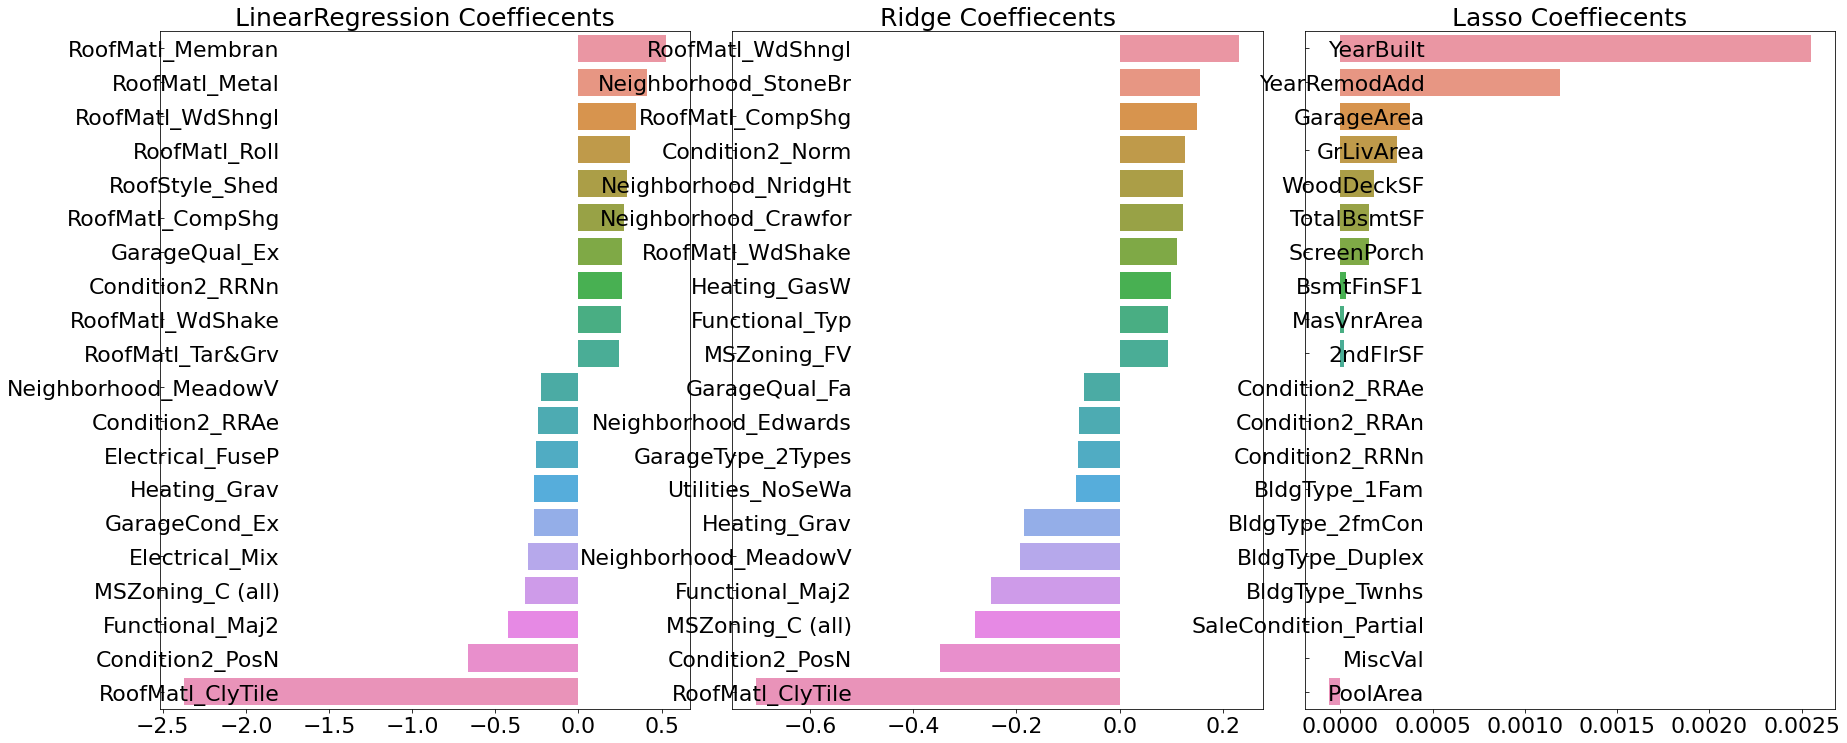

In [70]:
# 각 모델의 회귀 계수 시각화
models =[lr_reg,ridge_reg,lasso_reg]
visualize_coefficient(models)

# 결과
# LinearRegression과 Ridge의 경우는 회귀 계수가 유사한 형태로 분포
# 이에 비해 Lasso는 회귀 계수 값이 , YearBuilt외에는 매우 작음
# Lasso 회귀 모델의 경우 다른 두 모델과 다른 회귀 계수의 형태를 보임
# 이유가 학습 데이터의 데이터 분할에 있어서 나온 문제인지를 확인하기 위해 데이터를 학습/테스트 데이터로 분할하지 않고 전체 데이터 세트로 교차검증 해 평균 RMSE이 측정

## 전체 데이터 세트를 5개 교차 검증 폴드 세트로 분할 후 평균 RMSE 측정

In [65]:
from sklearn.model_selection import cross_val_score

def get_avg_rmse_cv(modles):
    for model in models:
        # 데이터 셋을 학습/테스트로 분할하지 않고 전체 데이터로 cross_val_score()수행 
        rmse_list = np.sqrt(-cross_val_score(model,x_features,y_target,scoring='neg_mean_squared_error',cv=5))
        rmse_avg = np.mean(rmse_list)
        print('\n{0} CV RMSE 값 리스트 : {1}'.format(model.__class__.__name__, np.round(rmse_list,3)))
        print('{0} CV 평균 RMSE 값 : {1}'.format(model.__class__.__name__, np.round(rmse_avg,3)))

In [66]:
models = [lr_reg,ridge_reg,lasso_reg]
get_avg_rmse_cv(models)

# 여전히 Lasso가 성능 낮음 


LinearRegression CV RMSE 값 리스트 : [0.135 0.165 0.168 0.111 0.198]
LinearRegression CV 평균 RMSE 값 : 0.155

Ridge CV RMSE 값 리스트 : [0.117 0.154 0.142 0.117 0.189]
Ridge CV 평균 RMSE 값 : 0.144

Lasso CV RMSE 값 리스트 : [0.161 0.204 0.177 0.181 0.265]
Lasso CV 평균 RMSE 값 : 0.198


In [75]:
# 최적화 alpha값 추출
# 모델과  하이퍼 파라미터 딕셔너리 객체를 받아 최적화 작업의 결과 표시하는 함수 
from sklearn.model_selection import GridSearchCV
def print_best_params(model, params):
    grid_model = GridSearchCV(model, param_grid=params, scoring='neg_mean_squared_error',cv=5)
    grid_model.fit(x_features,y_target)
    rmse=np.sqrt(-1*grid_model.best_score_)
    print('{0} 5 CV 시 최적 평균 RMSE 값 : {1}, 최적 alpha {2}'.format(model.__class__.__name__, np.round(rmse,4),grid_model.best_params_))


In [77]:
# ridge모델과 lasso모델의 최적화 alpha값을 추출 
ridge_params = {'alpha':[0.05,0.1,1,5,8,10,12,15,20]}
lasso_params = {'alpha':[0.001,0.005,0.008,0.05,0.03,0.1,0.5,1,5,10]}
print_best_params(ridge_reg,ridge_params)
print_best_params(lasso_reg,lasso_params)

# 결과
# ridge모델의 경우,
# alpha 최적화 후 최적 평균 RMSE값이 0.1418로 0.144 보다 예측 성능이 좋아짐
# lasso모델의 경우, 
# alpha 최적화 후 최적 평균이 RMSE값이 0.142로 0.198보다 예측 성능이 많이 좋아짐 

Ridge 5 CV 시 최적 평균 RMSE 값 : 0.1418, 최적 alpha {'alpha': 12}
Lasso 5 CV 시 최적 평균 RMSE 값 : 0.142, 최적 alpha {'alpha': 0.001}


## 선형 모델에 최적 alpha값 설정 후 학습 데이터와 테스트 데이터를 이용해 모델의 학습/예측/평가 수행

In [78]:
# 앞의 최적화 alpha값 이용해 예측 및 평가 수행 

lr_reg = LinearRegression()
lr_reg.fit(x_train,y_train)
ridge_reg = Ridge(alpha=12)
ridge_reg.fit(x_train,y_train)
lasso_reg = Lasso(alpha=0.001)
lasso_reg.fit(x_train,y_train)

# 3개 모델의 RMSE 출력
models = [lr_reg,ridge_reg,lasso_reg]
get_rmses(models)

# 결과
# alpha 최적화 후 테스트 데이터 세트의 예측 성능이 더욱 좋아짐

LinearRegression 로그 변환된 RMSE :  0.132
Ridge 로그 변환된 RMSE :  0.124
Lasso 로그 변환된 RMSE :  0.12


[0.1318957657915425, 0.12387044279987379, 0.11995999974065158]

## 모든 모델의 회귀 계수 시각화

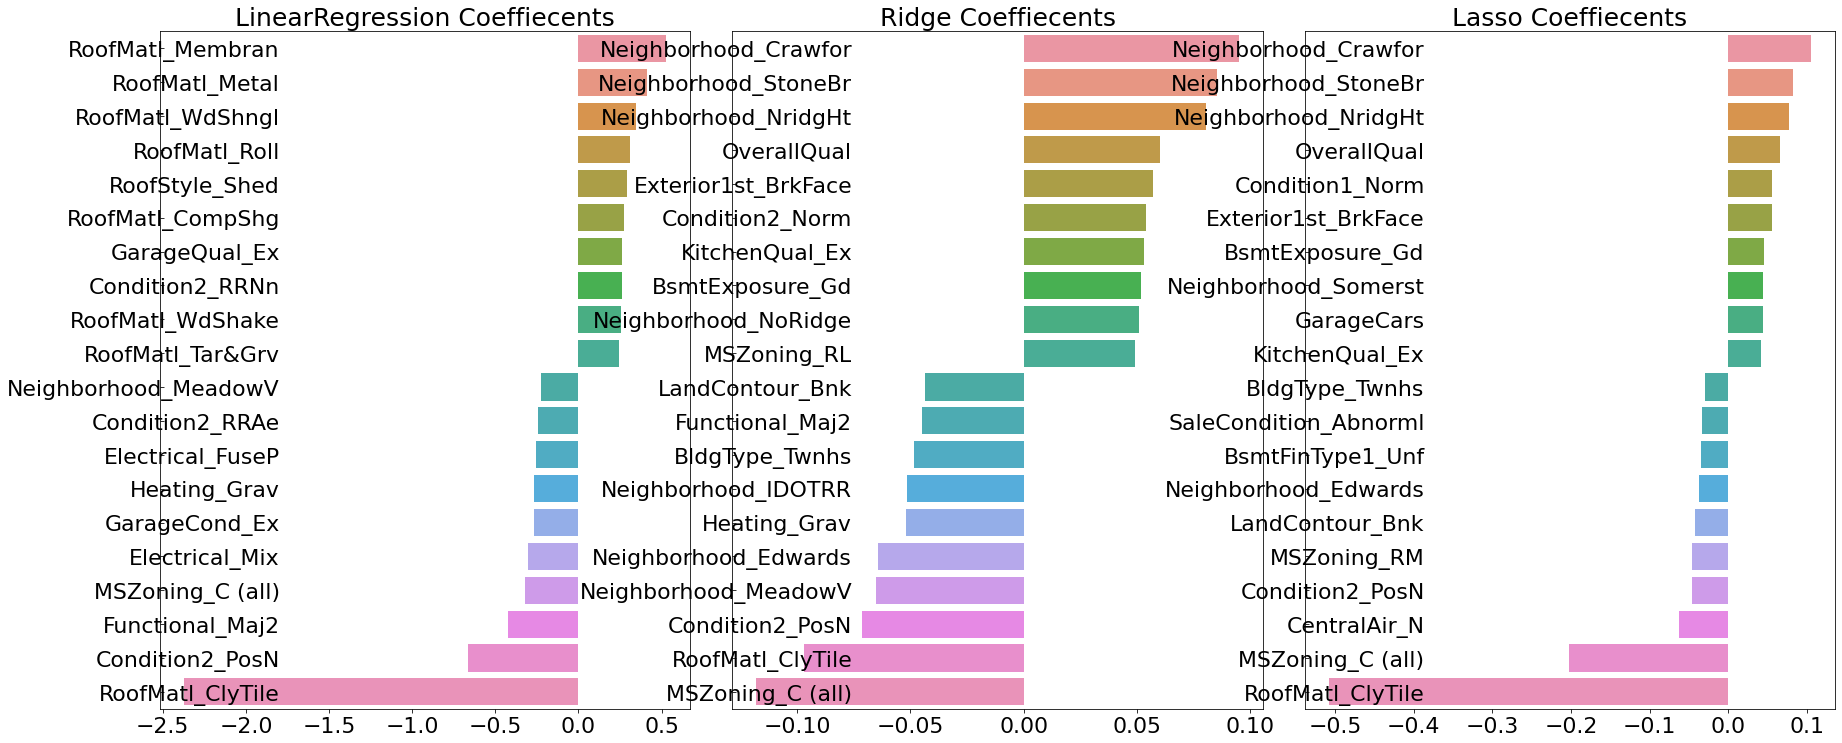

In [79]:
models = [lr_reg,ridge_reg,lasso_reg]
visualize_coefficient(models)

# 결과
# 기존에는 라쏘 모델의 회귀계수가 나머지 두 개 모델과 많은 차이가 있었지만
# 이번에는 릿지와 라쏘 모델에서 비슷한 피처의 회귀계수가 높음
# 다만, 라쏘 모델의 경우에는 릿지에 비해 동일한 피처라도 회귀계수의 값이 상당히 작음
# e.g. MSZoning_C, RoofMatl_ClyTile

## 데이터 세트를 추가 가공 후 모델 튜닝 진행
## 피처 데이터 세트의 분포도 확인
* 분포도 확인 이유?
* 피처 데이터 세트의 경우 지나치게 왜곡된 피처가 존재할 경우 회귀 예측 성능을 저하시킬 수 있음
* 모든 숫자형 피처의 데이터 분포도를 확인해 분포도 왜곡 정도 확인
* scipy stats모듈의 skew()이용 
    * 일반적으로 skew()함수의 반환 값이 1 이상인 경우 = 높은 왜곡
* 주의할 점 
    * skew()를 적용하는 숫자형 피처에서 원-핫 인코딩된 카데고리 숫자형 피처는 제외해야 함!
    * 코드성 피처이므로 당연히 왜곡될 가능성 높음 
    * e.g. 화장실 여부 1이 1,000건 0이 10건 ==> 왜곡과는 무관
    * 그래서 원-핫 인코딩 적용 전의 df사용


In [101]:
from scipy.stats import skew

# object가 아닌 숫자형 피처 컬럼의 index만 추출 
feature_index = house_df.dtypes[house_df.dtypes != 'object'].index

# house_df 컬럼 index를 []로 입력하면 해당하는 컬럼 데이터 세트 반환. apply lambda로 skew()호출
skew_features = house_df[feature_index].apply(lambda x : skew(x))

# skew(왜곡)정도가 1이상인 컬럼만 추출해 내림차순 정렬
skew_features_top = skew_features[skew_features>1]
print(skew_features_top.sort_values(ascending=False))

MiscVal          24.451640
PoolArea         14.813135
LotArea          12.195142
3SsnPorch        10.293752
LowQualFinSF      9.002080
KitchenAbvGr      4.483784
BsmtFinSF2        4.250888
ScreenPorch       4.117977
BsmtHalfBath      4.099186
EnclosedPorch     3.086696
MasVnrArea        2.673661
LotFrontage       2.382499
OpenPorchSF       2.361912
BsmtFinSF1        1.683771
WoodDeckSF        1.539792
TotalBsmtSF       1.522688
MSSubClass        1.406210
1stFlrSF          1.375342
GrLivArea         1.365156
dtype: float64


In [102]:
# 추출된 왜곡 정도가 높은 피처를 로그 변환
house_df[skew_features_top.index] = np.log1p(house_df[skew_features_top.index])

# 로그 변환 후 왜곡 정도를 다시 확인
print(skew_features_top.sort_values(ascending=False))

MiscVal          24.451640
PoolArea         14.813135
LotArea          12.195142
3SsnPorch        10.293752
LowQualFinSF      9.002080
KitchenAbvGr      4.483784
BsmtFinSF2        4.250888
ScreenPorch       4.117977
BsmtHalfBath      4.099186
EnclosedPorch     3.086696
MasVnrArea        2.673661
LotFrontage       2.382499
OpenPorchSF       2.361912
BsmtFinSF1        1.683771
WoodDeckSF        1.539792
TotalBsmtSF       1.522688
MSSubClass        1.406210
1stFlrSF          1.375342
GrLivArea         1.365156
dtype: float64


In [103]:
# house_df의 피처를 일부 로그 변환 했으므로 다시 원-핫 인코딩 적용한 df만들기
house_df_ohe = pd.get_dummies(house_df)
y_target = house_df_ohe['SalePrice']
x_features = house_df_ohe.drop('SalePrice',axis=1,inplace=False)
x_train,x_test,y_train,y_test = train_test_split(x_features,y_target,test_size=0.2,random_state=156)

# 피처를 로그 변환 후 다시 최적 하이퍼 파라미터와 RMSE이 출력
ridge_params = {'alpha':[0.05,0.1,1,5,8,10,12,15,20]}
lasso_params = {'alpha':[0.001,0.005,0.008,0.05,0.03,0.1,0.5,1,5,10]}
print_best_params(ridge_reg,ridge_params)
print_best_params(lasso_reg,lasso_params)

# 릿지모델의 경우 최적 alpha값이 12 -> 10으로 변경 
# 두 모델 모두 5폴드 교차 검증의 평균 RMSE값이 향상 
# 릿지의 경우 0.1418 -> 0.1275
# 라쏘의 경우 0.142 -> 0.1252


Ridge 5 CV 시 최적 평균 RMSE 값 : 0.1275, 최적 alpha {'alpha': 10}
Lasso 5 CV 시 최적 평균 RMSE 값 : 0.1252, 최적 alpha {'alpha': 0.001}


LinearRegression 로그 변환된 RMSE :  0.128
Ridge 로그 변환된 RMSE :  0.122
Lasso 로그 변환된 RMSE :  0.119


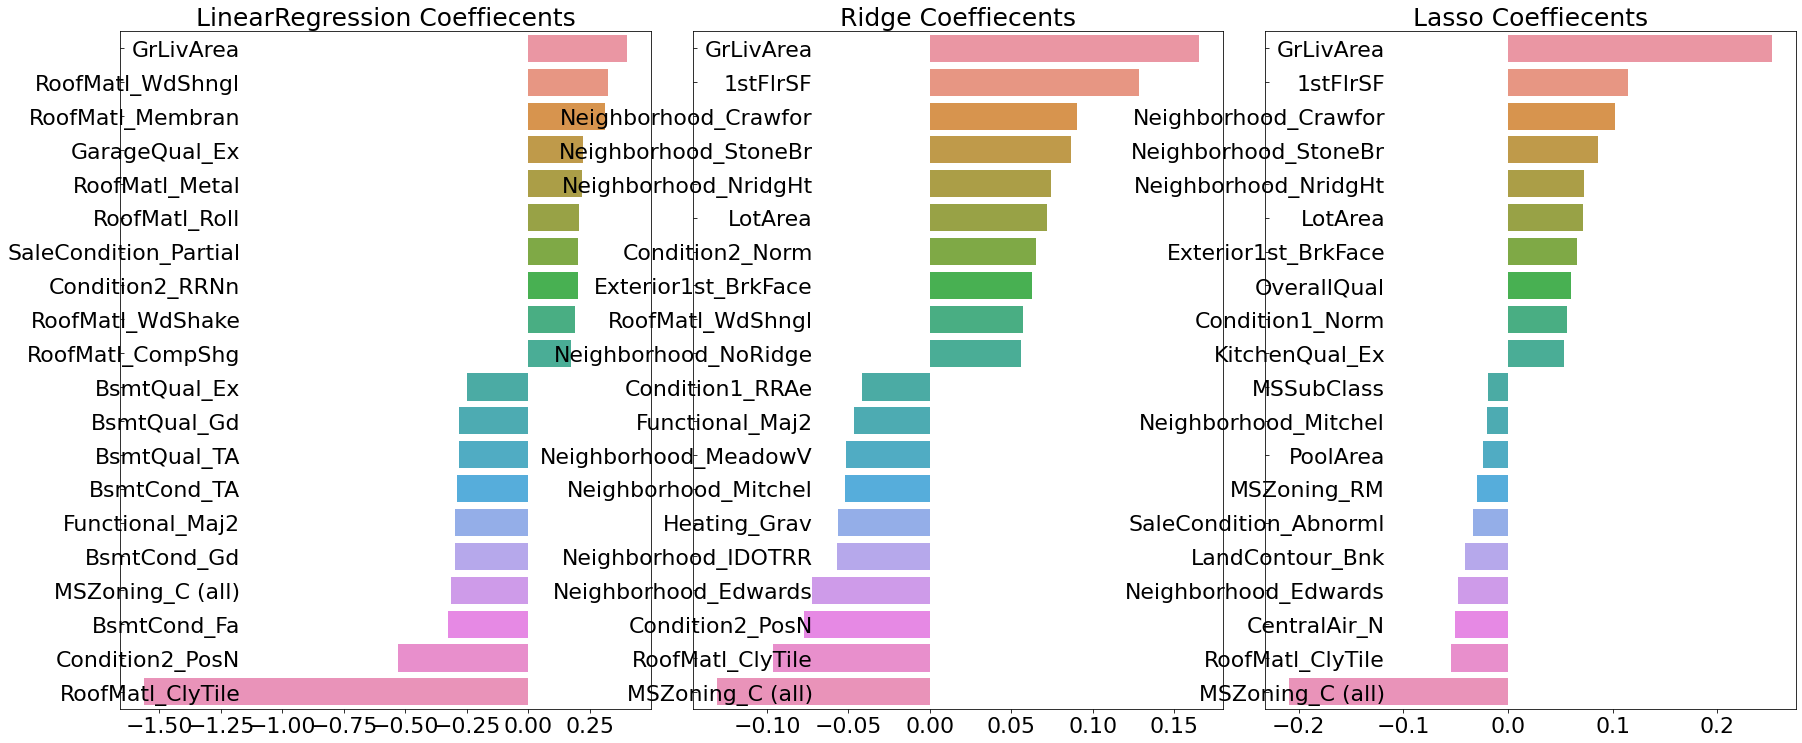

In [105]:
lr_reg = LinearRegression()
lr_reg.fit(x_train,y_train)
ridge_reg = Ridge(alpha=10)
ridge_reg.fit(x_train,y_train)
lasso_reg = Lasso(alpha=0.001)
lasso_reg.fit(x_train,y_train)

# 3개 모델의 RMSE 출력
models = [lr_reg,ridge_reg,lasso_reg]
get_rmses(models)


models = [lr_reg,ridge_reg,lasso_reg]
visualize_coefficient(models)

# 결과
# 3모델 모두 GrLivArea (주거 공간 크기)가 회귀계수가 가장 높은 피처가 되었음
# 주거 공간의 크기가 주택 가격에 미치는 영향이 당연히 제일 높을 것이라는 상식선에서의 결과가 이제야 도출

## 이상치 데이터 처리